# Adult Data Set Analisys

## Abstract
**About this Dataset**
US Adult Census is a database containing data relating income to social factors such as Age, Education, race etc.

The Us Adult income dataset was extracted by Barry Becker from the 1994 US Census Database. The data set consists of anonymous information such as occupation, age, native country, race, capital gain, capital loss, education, work class and more. Each row is labelled as either having a salary greater than ">50K" or "<=50K".

The goal here is to train a binary classifier on the training dataset to predict the column '__target__' which has two possible values ">50K" and "<=50K" and evaluate the accuracy of the classifier with the test dataset.

This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

## What are we going to use ?

In [ ]:
# Data structures
import random
import numpy as np
import pandas as pd

# Tools to better model the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

# Machine Learning Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Metrics and data visualization tools
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import pointbiserialr, spearmanr
import seaborn as sns

# %load 

In [ ]:
adult_data_frame = pd.read_csv("./input/adult.csv")

## Let's look at the data.

In [3]:
print(adult_data_frame.head())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

Data presented, with all if it's fetures. Some observations:
1. fnlwgt is a highly dispersive. This is a feature that is used to show the relevance of the individual in it's country. "How common is this type of adult in his country". We will leave this feature out of our analysis. 

2. Some of the values are non-numerical and they will be needed to be converted.

We'll start converting the features from strings to some sort of integer representation.
* For income we'll use a binary value to classify adults with over and under 50k income.
* For gender we'll use a binary value.

In [4]:
adult_data_frame['income'] = adult_data_frame['income'].map({'<=50K':1, '>50K':0}).astype(int)
adult_data_frame['gender'] = adult_data_frame['gender'].map({'Male':1,'Female':0}).astype(int)

For some of the features we'll look at their correlation. Maybe we can extract some information.

In [5]:
print (adult_data_frame[['native-country','income']].groupby(['native-country']).mean().sort_values(by=['income'], ascending=False))

                              income
native-country                      
Holand-Netherlands          1.000000
Guatemala                   0.965909
Outlying-US(Guam-USVI-etc)  0.956522
Columbia                    0.952941
Dominican-Republic          0.951456
Mexico                      0.950578
Nicaragua                   0.938776
El-Salvador                 0.929032
Trinadad&Tobago             0.925926
Vietnam                     0.918605
Peru                        0.913043
Laos                        0.913043
Honduras                    0.900000
Puerto-Rico                 0.891304
Haiti                       0.880000
Ecuador                     0.866667
Jamaica                     0.858491
Scotland                    0.857143
Thailand                    0.833333
South                       0.826087
Portugal                    0.820896
Poland                      0.804598
United-States               0.756023
Cuba                        0.753623
?                           0.743291
H

In [6]:
adult_data_frame['native-country'] = adult_data_frame['native-country'].replace(['France', 'England', 'Greece', 'Yugoslavia', 'Italy', 'Hungary', 'Ireland', 'Germany', 'Poland', 'Portugal', 'Scotland', 'Holand-Netherlands'], 'Europe')
adult_data_frame['native-country'] = adult_data_frame['native-country'].replace(['India', 'Taiwan', 'Iran', 'Japan', 'Cambodia', 'China', 'Philippines', 'Hong', 'South', 'Thailand','Laos', 'Vietnam'], 'Asia')
adult_data_frame['native-country'] = adult_data_frame['native-country'].replace(['Canada', 'Mexico', 'United-States', 'Outlying-US(Guam-USVI-etc)'], 'North-America')
adult_data_frame['native-country'] = adult_data_frame['native-country'].replace(['Cuba', 'Jamaica', 'Ecuador', 'Haiti', 'Puerto-Rico', 'Honduras', 'Peru', 'Trinadad&Tobago', 'El-Salvador', 'Nicaragua', 'Dominican-Republic', 'Columbia', 'Guatemala'], 'South&Central-America')
print (adult_data_frame[['native-country','income']].groupby(['native-country']).mean().sort_values(by=['income'], ascending=False))

                         income
native-country                 
South&Central-America  0.894737
North-America          0.759825
?                      0.743291
Asia                   0.713504
Europe                 0.705128


We observe that there is some disparaty between the continents, and we choose to use it as a more powerfull and efficient feature than country.

I will also remove the mistaken data marked as ?

In [7]:
print(adult_data_frame.shape)
adult_data_frame['native-country'] = adult_data_frame['native-country'].replace('?',np.nan)
adult_data_frame['workclass'] = adult_data_frame['workclass'].replace('?',np.nan)
adult_data_frame['occupation'] = adult_data_frame['occupation'].replace('?',np.nan)

adult_data_frame.dropna(how='any',inplace=True)
print (adult_data_frame.shape)

(48842, 15)
(45222, 15)


In [8]:
adult_data_frame[['workclass','income']].groupby(['workclass']).mean()

,income
workclass,
Federal-gov,0.609531
Local-gov,0.704839
Private,0.782298
Self-emp-inc,0.445930
Self-emp-not-inc,0.721022
State-gov,0.732785
Without-pay,0.904762


We could organize this data bettter, for example into: Private, and Public sectors, but we don't expect a great improvement from it. We are only going to change some of the features that prove a significant disparaty.

In [9]:
adult_data_frame.describe()

,age,fnlwgt,educational-num,gender,capital-gain,capital-loss,hours-per-week,income
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,0.675048,1101.430344,88.595418,40.938017,0.752156
std,13.217870,1.056392e+05,2.552881,0.468362,7506.430084,404.956092,12.007508,0.431766
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,0.000000,40.000000,1.000000
50%,37.000000,1.783160e+05,10.000000,1.000000,0.000000,0.000000,40.000000,1.000000
75%,47.000000,2.379260e+05,13.000000,1.000000,0.000000,0.000000,45.000000,1.000000
max,90.000000,1.490400e+06,16.000000,1.000000,99999.000000,4356.000000,99.000000,1.000000


In the following table we are able to see the influence that the relationship status has on the targeted outcome. On the original dataset, the outliers, 0 and 9 are 'Husbands' and 'Wifes', therefore, couples, while the rest of the labels are 'Divorced' ,'Married-spouse-absent' ,'Never-married' ,'Separated', 'Widowed'.

Given the obvious difference between the Singles and Couples, we are going to alter the column so that we will only have the 'Single' and 'Couple' labels.

In [10]:
adult_data_frame[['relationship','income']].groupby(['relationship']).mean()

,income
relationship,
Husband,0.544252
Not-in-family,0.895061
Other-relative,0.962936
Own-child,0.984153
Unmarried,0.936926
Wife,0.514108


In [11]:
adult_data_frame['marital-status'] = adult_data_frame['marital-status'].replace(['Divorced','Married-spouse-absent','Never-married','Separated','Widowed'], 'Single')
adult_data_frame['marital-status'] = adult_data_frame['marital-status'].replace(['Married-AF-spouse','Married-civ-spouse'], 'Couple')
adult_data_frame[['marital-status','income']].groupby(['marital-status']).mean()


,income
marital-status,
Couple,0.545787
Single,0.932463


In [12]:
adult_data_frame['native-country'].unique()

array(['North-America', 'South&Central-America', 'Europe', 'Asia'],
      dtype=object)

In [13]:
adult_data_frame['workclass'] = adult_data_frame['workclass'].map({'Private':0, 'Local-gov':1, 'Self-emp-not-inc':2, 'Federal-gov':3,
       'State-gov':4, 'Self-emp-inc':5, 'Without-pay':6}).astype(int)
adult_data_frame.drop(labels=['fnlwgt', 'education','occupation', 'race'],axis=1,inplace=True)
adult_data_frame['marital-status'] = adult_data_frame['marital-status'].map({'Single':0, 'Couple': 1}).astype(int)
adult_data_frame['relationship'] = adult_data_frame['relationship'].map({'Own-child':0, 'Husband':1, 'Not-in-family':2, 'Unmarried':3, 'Wife':4,
       'Other-relative':5}).astype(int)
adult_data_frame['native-country'] = adult_data_frame['native-country'].map({'North-America':0, 'South&Central-America':1, 'Europe':2, 'Asia':3})
adult_data_frame.head(10)

,age,workclass,educational-num,marital-status,relationship,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,0,7,0,0,1,0,0,40,0,1
1,38,0,9,1,1,1,0,0,50,0,1
2,28,1,12,1,1,1,0,0,40,0,0
3,44,0,10,1,1,1,7688,0,40,0,0
5,34,0,6,0,2,1,0,0,30,0,1
7,63,2,15,1,1,1,3103,0,32,0,0
8,24,0,10,0,3,0,0,0,40,0,1
9,55,0,4,1,1,1,0,0,10,0,1
10,65,0,9,1,1,1,6418,0,40,0,0
11,36,3,13,1,1,1,0,0,40,0,1


In [14]:
print (adult_data_frame.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 11 columns):
age                45222 non-null int64
workclass          45222 non-null int32
educational-num    45222 non-null int64
marital-status     45222 non-null int32
relationship       45222 non-null int32
gender             45222 non-null int32
capital-gain       45222 non-null int64
capital-loss       45222 non-null int64
hours-per-week     45222 non-null int64
native-country     45222 non-null int64
income             45222 non-null int32
dtypes: int32(5), int64(6)
memory usage: 3.3 MB
None


Next we want to plot the correlation matrix of the data set. This will help us establish if there are some features that are more correlated than others. 

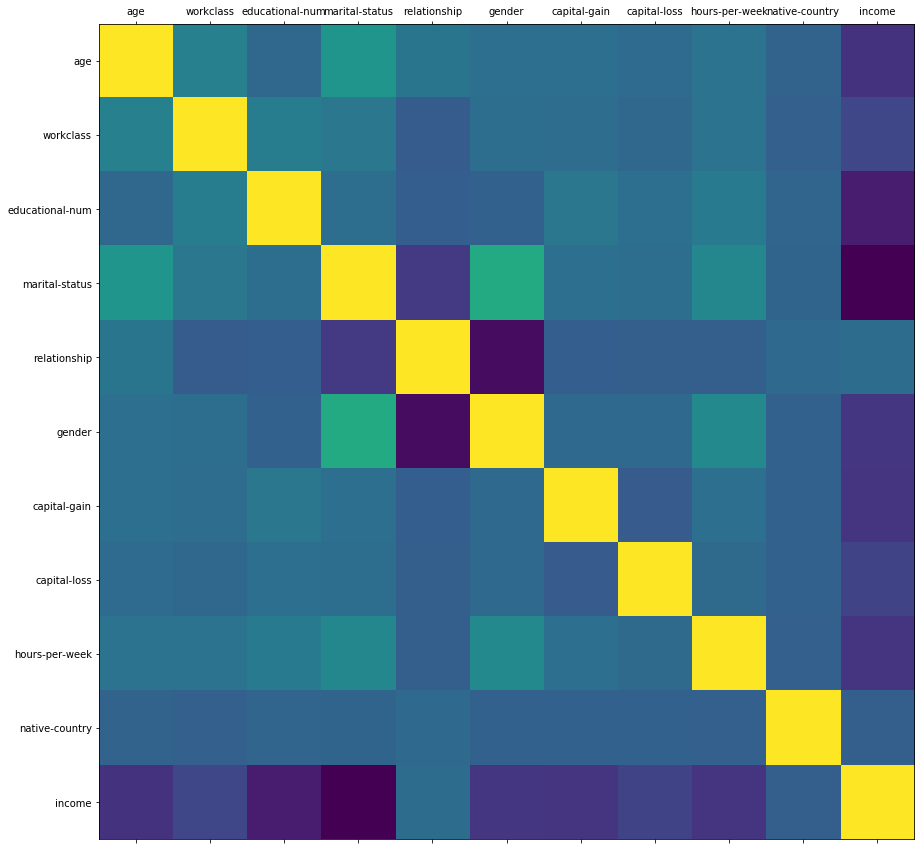

In [15]:
def plot_correlation(adult_data_frame, size=15):
    corr= adult_data_frame.corr()
    fig, ax =plt.subplots(figsize=(size,size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show()
plot_correlation(adult_data_frame)

Here we can observe some interesting things about the features and how they correlate to the target. We can easily see that educational-num is higly influential for the outcome.

In [16]:
param=[]
abs_corr=[]

for c in adult_data_frame.columns.values:
    
    #Check if binary or continuous
    if c != "income":
        if len(adult_data_frame[c].unique()) <= 2:
            corr = spearmanr(adult_data_frame['income'],adult_data_frame[c])[0]
        else:
            corr = pointbiserialr(adult_data_frame['income'],adult_data_frame[c].astype(int))[0]
        param.append(c)
        abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,abs_corr
parameter,
marital-status,0.446772
educational-num,0.332800
age,0.237040
hours-per-week,0.227199
capital-gain,0.221034
gender,0.215760
capital-loss,0.148687
workclass,0.137756
relationship,0.067427


At eye-sight, we observe that sex adn relationship status are higly correlated between each other. The same can be said about age:marital-status and age:relationship.

Regarding the target, we observe that education-num, relationship sex, capital-gain, and hours-per-week are highly correlated with our objective.

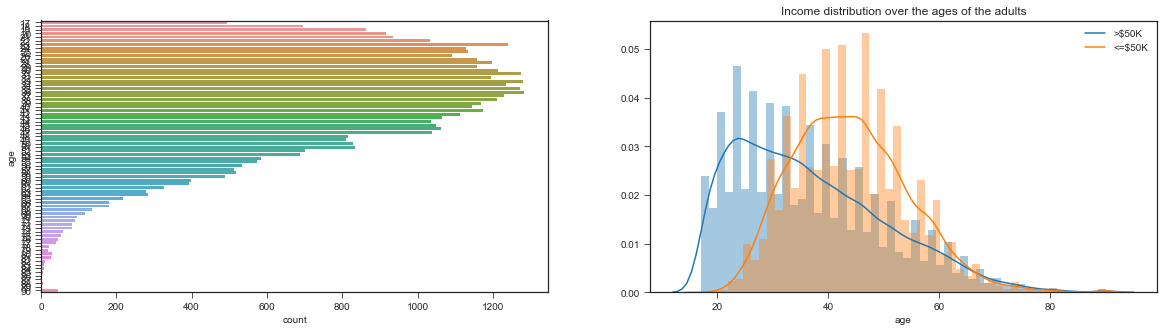

In [17]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age", data=adult_data_frame)
plt.subplot(1, 2, 2)
sns.distplot(adult_data_frame[adult_data_frame['income'] == 1]['age'], kde_kws={"label": ">$50K"})
sns.distplot(adult_data_frame[adult_data_frame['income'] == 0]['age'], kde_kws={"label": "<=$50K"}).set_title('Income distribution over the ages of the adults')
plt.show()

### Feature selection



In [18]:
y= adult_data_frame['income']
X= adult_data_frame.drop(['income'],axis=1)

### 0. Pre-processing the data

Before fitting any of the machines, we have to pre-process the data. 

1. First we are going to split it intro training and test data. The ratio I chose is 20/80. The seed is randomly generated as an integerg between 1 and 99. 

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(X,y,test_size=0.2,random_state=random.randint(1, 99))

print ("Train dataset: {0}{1}".format(train_data.shape, train_labels.shape))
print ("Test dataset: {0}{1}".format(test_data.shape, test_labels.shape))

Train dataset: (36177, 10)(36177,)
Test dataset: (9045, 10)(9045,)


# Predictions
In making the predictions we are going to use multiple algorithms and try to identify the best one. 
Algorithms used are:
1. Random Forest Trees
2. Logistic Regression
3. Support Vector Machine 

### 1. Random Forest Trees
In random forests each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

print(train_data.shape)

#Scaling the data
qt = QuantileTransformer(output_distribution='uniform')
train_data = qt.fit_transform(train_data)
test_data = qt.transform(test_data)

X_train, X_test = train_data, test_data
y_train, y_test = train_labels, test_labels
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=random.randint(1, 99))
clf.fit(X_train, y_train)
combined = clf.predict_proba(X_test)[:, 1]
rounded = np.round(combined)

print('Accuracy:', accuracy_score(rounded, y_test))
print('F1 score:', f1_score(rounded, y_test))

(36177, 10)
Accuracy: 0.8057490326147042
F1 score: 0.8858423754142031


### 2. Support Vector Machines

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

In [21]:
# Preprocess Data
# This Scaler is used according to the results obtained in DataScalaionComparison
# qt = QuantileTransformer(output_distribution='uniform')
# train_data = qt.fit_transform(train_data)
# test_data = qt.transform(test_data)

print ('ok')

#Fit Machine
LSVC = SVC(kernel='linear', random_state=0, tol=1e-5, C=0.1)
LSVC.fit(train_data, train_labels)
LSVC_prediction = LSVC.predict(test_data)

print('ok')

rounded = np.round(LSVC_prediction)

print('Accuracy:', accuracy_score(rounded, test_labels))
print('F1 score:', f1_score(rounded, test_labels))

PolySVM = SVC(kernel='poly')
PolySVM.fit(train_data, train_labels)
PolySVM_prediction = PolySVM.predict(test_data)

rounded = np.round(PolySVM_prediction)

print('Accuracy:', accuracy_score(rounded, test_labels))
print('F1 score:', f1_score(rounded, test_labels))

RBFSVM = SVC(kernel='rbf', C = 1, tol = 1e-3)
RBFSVM.fit(train_data, train_labels)
RBFSVM_prediction = RBFSVM.predict(test_data)

rounded = np.round(RBFSVM_prediction)

print('Accuracy:', accuracy_score(rounded, test_labels))
print('F1 score:', f1_score(rounded, test_labels))

SigmoidSVM = SVC(kernel='sigmoid')
SigmoidSVM.fit(train_data, train_labels)
SigmoidSVM_prediction = SigmoidSVM.predict(test_data)

rounded = np.round(SigmoidSVM_prediction)

print('Accuracy:', accuracy_score(rounded, test_labels))
print('F1 score:', f1_score(rounded, test_labels))

ok
ok
Accuracy: 0.8388059701492537
F1 score: 0.8955886565454025


c:\users\rares\pycharmprojects\penn-ml-library-project\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

### 3. Logistical Regression

In [ ]:
def logReg(adult_data, adult_labels):

    #Split Data
    train_data, test_data, train_labels, test_labels = train_test_split(adult_data, adult_labels, test_size=0.2,
                                                                        random_state=random.randint(1, 99))

    # Preprocess Data
    # This Scaler is used according to the results obtained in DataScalaionComparison for Logistical Regression
    qt = QuantileTransformer(output_distribution='uniform')
    train_data = qt.fit_transform(train_data)
    test_data = qt.transform(test_data)

    #Fit Machine
    logreg = LogisticRegression(C = 0.1, max_iter= 1000, penalty= "l1", solver="saga")
    logreg.fit(train_data, train_labels)

    # Best Parameters
    # Used Grid Search CV to find the best hyper-parameters to tune Logistical Regression machine.
    # Winning combination: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
    # Gained around 0.8-1 % accuracy

    # grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1"], "solver": ["saga"], "max_iter": [100, 1000, 10000, 100000]}  # l1 lasso l2 ridge
    # logreg_cv = GridSearchCV(logreg, grid, cv=5)
    # logreg_cv.fit(train_data, train_labels)

    # print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
    # print("accuracy :", logreg_cv.best_score_)
    # print(logreg_cv.cv_results_)

    #Predict
    logreg_prediction = logreg.predict(test_data)
    
    rounded = np.round(logreg_prediction)

    print('Accuracy:', accuracy_score(rounded, test_labels))
    print('F1 score:', f1_score(rounded, test_labels))
logReg(X, y)

#     return np.count_nonzero(np.equal(test_labels, logreg_prediction)) * 100 / logreg_prediction.size

### 4. Decision Tree Classifier
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

For instance, in the example below, decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

In [ ]:
tree_count = 10
bag_proportion = 0.6
predictions = []

#Scaling the data
qt = QuantileTransformer(output_distribution='uniform')
train_data = qt.fit_transform(train_data)
test_data = qt.transform(test_data)

for i in range(tree_count):
    X_train, X_test = train_data, test_data
    y_train, y_test = train_labels, test_labels
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=75)
    clf.fit(X_train, y_train)
    predictions.append(clf.predict_proba(X_test)[:, 1])

combined = np.sum(predictions, axis=0) / 10
rounded = np.round(combined)

print('Accuracy:', accuracy_score(rounded, y_test))
print('F1 score:', f1_score(rounded, y_test))

## Behind the scenes

###  Data Scaling
We chose to scale the data. The scaler used was chosen after comparing multiple scalers. This improved the accuracy of the models by 2-3%.

In [ ]:
X_train = train_data
X_test = test_data
y_train = train_labels
y_test = test_labels

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

logreg = LogisticRegression( solver='lbfgs' )

distributions = [
    ('Unscaled data', X_train),
    ('Data after standard scaling',
        StandardScaler()),
    ('Data after min-max scaling',
        MinMaxScaler()),
    ('Data after max-abs scaling',
        MaxAbsScaler()),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75))),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson')),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        ),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        ),
    ('Data after sample-wise L2 normalizing',
        Normalizer()),
]

for i in range (1, len(distributions)):
    scaler = distributions[i][1]
    train_data = scaler.fit_transform(X_train);
    test_data = scaler.transform(X_test)

    logreg.fit(train_data, train_labels)

    logreg_prediction = logreg.predict(test_data)

    logreg_result = np.count_nonzero(np.equal(test_labels, logreg_prediction)) * 100 / logreg_prediction.size
    print(distributions[i][0], ": ", logreg_result)

### Hyper-parameter optimization
We used Grid Search to find the best hyper-parameters for each of the machines we deployed. 

In [ ]:
#     Best Parameters
#     Used Grid Search CV to find the best hyper-parameters to tune Logistical Regression machine.
#     Winning combination: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
#     Gained around 0.8-1 % accuracy

from sklearn.model_selection import GridSearchCV
grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1"], "solver": ["saga"], "max_iter": [100, 1000, 10000, 100000]}  
# l1 lasso l2 ridge
logreg_cv = GridSearchCV(logreg, grid, cv=5)
logreg_cv.fit(train_data, train_labels)

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :", logreg_cv.best_score_)
print(logreg_cv.cv_results_)

### Sources
1. https://scikit-learn.org/stable/modules/tree.html#tree
2. https://www.kaggle.com/overload10/adult-census-dataset
3. https://scikit-learn.org/stable/modules/svm.html